# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies NOM data sets in NMDC, filters those datasets based on quality control metrics, and analyzes the molecular composition of the chosen datasets via heatmaps and Van Krevelen plots.

In [1]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
#import nom_functions.py in second_omics_type folder as module to utilize its functions
import nom_functions as func

### Gather the IDs for processed NOM results in NMDC by filtering for data objects of type "FT ICR-MS"

Using the python requests library and the [NMDC metadata endpoint](https://api.microbiomedata.org/docs#/metadata/list_from_collection_nmdcschema__collection_name__get), we can filter the collection `data_object_set` by type “FT ICR-MS Analysis Results” to gather processed NOM results. More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md). The function get_next_results and its documentation can be found in nom_functions.py within this folder.

In [2]:
# pull all NOM data objects
processed_nom=func.get_next_results(collection='data_object_set',\
                       filter='{"data_object_type":{"$regex": "FT ICR-MS Analysis Results"}}',\
                        max_page_size=100,fields='id,md5_checksum,url')

# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = func.convert_df(processed_nom)
processed_nom_df

,processed_nom_id,processed_nom_md5_checksum,processed_nom_url
0,nmdc:dobj-11-00dewm52,2a532dca15798e470103ebd752a0937f,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
1,nmdc:dobj-11-00wm3313,3ce562ac512457ea54bdda05a4f01ede,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
2,nmdc:dobj-11-01kye625,38930c28eae561bc807bd01823f04167,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:dobj-11-02trja88,e6bafa5fabbebfb0061aa2587e223979,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
4,nmdc:dobj-11-0312n668,20a5193d5fb54bf2a54c54b6f95a099d,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...
2542,nmdc:dobj-13-zrp1qw41,98b97b78fff542b66e72f4b3f792d80f,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
2543,nmdc:dobj-13-zsqpnm92,3e9e19910edb209d211d9f915e36b8cb,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
2544,nmdc:dobj-13-zvnmsp76,aec0521d6a36a440e41052f8eadc0d1d,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
2545,nmdc:dobj-13-zvzx2462,9f0d52cc46d247b8d2ba12d5842b9fb6,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...


### Continue traversing the NMDC schema by using the list of identifiers from the previous API call to query the next collection

Find the analysis records that produced these processed nom object IDs by matching object `ID` to the `has_output` slot in the collection `nom_analysis_activity_set`.

In [3]:
analysis_dataobj=func.get_id_results(
                                    newest_results=processed_nom,\
                                    id_field="processed_nom_id",\
                                    query_collection="nom_analysis_activity_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = func.convert_df(analysis_dataobj)
analysis_dataobj_df



,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-fwhgp651.1,[nmdc:dobj-11-hrqfj247],[nmdc:dobj-11-0dn7p856]
1,nmdc:wfnom-11-snvsmz18.1,[nmdc:dobj-11-esgqw196],[nmdc:dobj-11-0bmapy68]
2,nmdc:wfnom-11-ph9mfs20.1,[nmdc:dobj-11-sj597780],[nmdc:dobj-11-04v02904]
3,nmdc:wfnom-11-x8j6qc18.1,[nmdc:dobj-11-jjmn7962],[nmdc:dobj-11-1qhx4085]
4,nmdc:wfnom-11-479gvz55.1,[nmdc:dobj-11-rq95kp39],[nmdc:dobj-11-0cf8jk36]
...,...,...,...
2542,nmdc:wfnom-13-ycxczw19.1,[nmdc:dobj-13-w9czqg70],[nmdc:dobj-13-yasv1664]
2543,nmdc:wfnom-13-b2e44434.1,[nmdc:dobj-13-aef3pw71],[nmdc:dobj-13-ykh2yk18]
2544,nmdc:wfnom-13-eb5f8063.1,[nmdc:dobj-13-b28x6912],[nmdc:dobj-13-xstcrm22]
2545,nmdc:wfnom-13-k9tdtt72.1,[nmdc:dobj-13-g1wmqa90],[nmdc:dobj-13-zkgr9031]


Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `ID` slot in the collection `data_object_set`.

In [4]:
raw_dataobj=func.get_id_results(
                                    newest_results=analysis_dataobj,\
                                    id_field="analysis_has_input",\
                                    query_collection="data_object_set",\
                                    match_id_field="id",\
                                    query_fields="id,name")
# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

raw_df = func.convert_df(raw_dataobj)

raw_df

,raw_id,raw_name
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...
...,...,...
2542,nmdc:dobj-13-ww59kg97,output: Unground_SBR_Spring_2014_FC_S2_10-20_M...
2543,nmdc:dobj-13-ym2bx698,output: Unground_SBR_Spring_2014_FC_S2_00-10_H...
2544,nmdc:dobj-13-zazrqk87,output: Brodie_185_w_r1_01Feb19_HESI_neg
2545,nmdc:dobj-13-zjrg8w43,output: Brodie_184_H2O_11Mar19_R1_HESI_Neg


Find the omics processing records that produced these raw data objects by matching the data object's `ID` slot to the `has_output` slot in the collection `omics_processing_set`.

In [5]:
omicsprocess_dataobj=func.get_id_results(
                                    newest_results=raw_dataobj,\
                                    id_field="raw_id",\
                                    query_collection="omics_processing_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in omicsprocess_dataobj:
    dataobject["omicsprocess_id"] = dataobject.pop("id")
    dataobject["omicsprocess_has_output"] = dataobject.pop("has_output")
    dataobject["omicsprocess_has_input"] = dataobject.pop("has_input")
# convert to data frame
omicsprocess_dataobj_df = func.convert_df(omicsprocess_dataobj)
omicsprocess_dataobj_df


,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:omprc-11-adjx8k29,[nmdc:dobj-11-04embv91],[nmdc:bsm-11-ax989290]
1,nmdc:omprc-11-w1kvtj73,[nmdc:dobj-11-04ny1n21],[nmdc:bsm-11-qvtb2v69]
2,nmdc:omprc-11-rj3bqn04,[nmdc:dobj-11-09p17z03],[nmdc:bsm-11-6aqn1d84]
3,nmdc:omprc-11-a1szxs11,[nmdc:dobj-11-0cmhqk17],[nmdc:bsm-11-b7c2dc48]
4,nmdc:omprc-11-sc2gv291,[nmdc:dobj-11-0rgvyp97],[nmdc:bsm-11-m1cbn542]
...,...,...,...
2542,nmdc:omprc-13-agdd4h68,[nmdc:dobj-13-ww59kg97],[nmdc:bsm-13-ty597764]
2543,nmdc:omprc-13-820dfq84,[nmdc:dobj-13-ym2bx698],[nmdc:bsm-13-rrsd4804]
2544,nmdc:omprc-11-5y5txf92,[nmdc:dobj-13-zazrqk87],[nmdc:bsm-11-4sw8dr23]
2545,nmdc:omprc-11-077nww93,[nmdc:dobj-13-zjrg8w43],[nmdc:bsm-11-afgbs159]


Find the biosample data objects used as input for these omics processing records by matching the processing record's `has_input` slot to the `ID` slot in the collection `biosample_set`.

In [6]:
biosample_dataobj=func.get_id_results(
                                    newest_results=omicsprocess_dataobj,\
                                    id_field="omicsprocess_has_input",\
                                    query_collection="biosample_set",\
                                    match_id_field="id",\
                                    query_fields="")

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = func.convert_df(biosample_dataobj)

biosample_dataobj_df


,part_of,env_broad_scale,env_local_scale,env_medium,samp_name,emsl_biosample_identifiers,carb_nitro_ratio,collection_date,cur_vegetation,depth,...,img_identifiers,insdc_biosample_identifiers,add_date,location,mod_date,tot_org_carb,sample_link,community,alternative_identifiers,igsn_biosample_identifiers
0,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'urban biome [ENVO:01000249]...,{'has_raw_value': 'woodland clearing [ENVO:000...,{'has_raw_value': 'forest soil [ENVO:00002261]...,WLUP_CoreB_TOP,[UUID:WLUP-CB-T-a07898a8-bff9-4bc2-ae4c-345682...,{'has_raw_value': '15.699'},{'has_raw_value': '2022-04-04T00:00:00'},"{'has_raw_value': 'Deciduous trees, skunk cabb...","{'has_minimum_numeric_value': 0.0, 'has_maximu...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:00000516', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",Lybrand_Permafrost_BOG_12_H2O,NaN,NaN,{'has_raw_value': '2018-07-22 00:00:00'},NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[nmdc:sty-11-8xdqsn54],"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:01000888', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'anthropogenic terrestrial b...,{'has_raw_value': 'agricultural field [ENVO:00...,{'has_raw_value': 'agricultural soil [ENVO:000...,PRS2_CoreB_TOP,[UUID:PSR2-CB-T-177b015d-e006-4aca-977d-c9c118...,{'has_raw_value': '9.6'},{'has_raw_value': '2022-02-04'},NaN,"{'has_minimum_numeric_value': 0.0, 'has_maximu...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:01000861', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",Lybrand_Permafrost_HE_02_CHCl3,NaN,NaN,{'has_raw_value': '2018-07-18 00:00:00'},NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW N3_00_10,[emsl:63ca3868-6647-11eb-ae93-0242ac130002],NaN,{'has_raw_value': '2014-04-01'},NaN,NaN,...,NaN,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,microbial communities,NaN,NaN
2166,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S2_00_10,[emsl:63ca47e0-6647-11eb-ae93-0242ac130002],NaN,{'has_raw_value': '2014-04-01'},NaN,NaN,...,NaN,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,microbial communities,NaN,NaN
2167,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S3_30_40,[emsl:63ca5014-6647-11eb-ae93-0242ac130002],NaN,{'has_raw_value': '2014-04-01'},NaN,NaN,...,NaN,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,microbial communities,NaN,NaN
2168,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S2_10_20,[emsl:63ca489e-6647-11eb-ae93-0242ac130002],NaN,{'has_raw_value': '2014-04-01'},NaN,NaN,...,NaN,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,microbial communities,NaN,NaN


### Create final data frame of relevant metadata and NMDC schema information for each data set

Assign a general type for each sample by parsing their ENVO IDs. This was done manually by searching ENVO ID's on the [ontology search website](https://www.ebi.ac.uk/ols4/ontologies/envo).

In [7]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=func.convert_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type_gen']=""

biosample_dataobj_flat_df['env_medium.term.id'].drop_duplicates()

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002261","ENVO:00001998","ENVO:00002259",
                                                                                    "ENVO:01001616","ENVO:00005750","ENVO:00005761",
                                                                                    "ENVO:00005760","ENVO:00005773","ENVO:00005802",
                                                                                    "ENVO:00005774"]),'sample_type_gen'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042"]),'sample_type_gen'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007"]),'sample_type_gen'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000017"]),'sample_type_gen'] = 'sand'

#filter to desired metadata columns
biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','geo_loc_name.has_raw_value','env_medium.term.name','env_medium.term.id','sample_type_gen']]

biosample_dataobj_flat_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type_gen
0,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil
1,nmdc:bsm-11-17ag3b30,"USA: Alaska, Coldfoot",soil,ENVO:00001998,soil
2,nmdc:bsm-11-26bgjj05,"USA: ND, Stutsman",NaN,ENVO:00001998,soil
3,nmdc:bsm-11-2d3eam48,"USA: Washington, Prosser Non-irrigated Bare",agricultural soil,ENVO:00002259,soil
4,nmdc:bsm-11-2n9dds87,"USA: Alaska, Healy",soil,ENVO:00001998,soil
...,...,...,...,...,...
2165,nmdc:bsm-13-q0qxrf57,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand
2166,nmdc:bsm-13-rrsd4804,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand
2167,nmdc:bsm-13-tr7n0581,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand
2168,nmdc:bsm-13-ty597764,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand


Create merged dataframe with results from schema traversal and metadata

In [8]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=func.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output",[],["analysis_has_input","analysis_has_output"])

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=func.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input",[],[])

#match processed_obj_to_raw_df (via raw_id) to omics processing objects (via omicsprocess_has_output) and expand lists has_input and has_output
processed_obj_to_omicsprocess_df=func.merge_df(processed_obj_to_raw_df,omicsprocess_dataobj_df,"raw_id","omicsprocess_has_output",[],["omicsprocess_has_input","omicsprocess_has_output"])

#match biosample objects (via biosample_id) to processed_obj_to_omicsprocess_df (via omicsprocess_has_input)
merged_df=func.merge_df(biosample_dataobj_flat_df,processed_obj_to_omicsprocess_df,"biosample_id","omicsprocess_has_input",[],[])

merged_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type_gen,raw_id,raw_name,processed_nom_id,processed_nom_md5_checksum,processed_nom_url,analysis_id,analysis_has_input,analysis_has_output,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-gdhnkg66,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...,nmdc:dobj-11-0dyc2f79,9ace043441672422f7991411014ab9cb,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-gdhnkg66,nmdc:bsm-11-12esnc57
1,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-vkheqz50,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...,nmdc:dobj-11-07gsmc68,9363e9de79c39013257ddb4d967006b2,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:omprc-11-s2590964,nmdc:dobj-11-vkheqz50,nmdc:bsm-11-12esnc57
2,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-qt6pmm77,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...,nmdc:dobj-11-jj2r0a49,a502ec422a6f960972b759b143d8ad9c,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-qt6pmm77,nmdc:bsm-11-12esnc57
3,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-z002ga43,1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...,nmdc:dobj-11-mmdwds36,dff9718e9428ec3aa77fed987deb637d,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-zr24j979.1,nmdc:dobj-11-z002ga43,nmdc:dobj-11-mmdwds36,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-z002ga43,nmdc:bsm-11-12esnc57
4,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-hdd01t09,1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...,nmdc:dobj-11-s42fww29,05cf8e9c0394dbdf80c3c6b89a4f3956,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-befkpb58.1,nmdc:dobj-11-hdd01t09,nmdc:dobj-11-s42fww29,nmdc:omprc-11-mcataq54,nmdc:dobj-11-hdd01t09,nmdc:bsm-11-12esnc57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9621,nmdc:bsm-13-zxqyyz58,"USA: Minnesota, Marcel Experimental Forest, Sp...",NaN,ENVO:00005774,soil,nmdc:dobj-13-y1we6577,Rachael_21T_19-87_M_03Mar17_leopard_Infuse.raw,nmdc:dobj-13-jmv5e702,03a41ac4ad0381c412b3a55b06633cfa,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-s9ez8969.1,nmdc:dobj-13-y1we6577,nmdc:dobj-13-jmv5e702,nmdc:omprc-13-pbbt1t23,nmdc:dobj-13-y1we6577,nmdc:bsm-13-zxqyyz58
9622,nmdc:bsm-11-hbdmpd66,USA: Colorado,NaN,ENVO:00005802,soil,nmdc:dobj-13-9za40068,output: Brodie_153_w_r2_29Jan19_HESI_neg,nmdc:dobj-13-qxc45786,927a408981415d70c2111b54f37299da,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-meh2bb53.1,nmdc:dobj-13-9za40068,nmdc:dobj-13-qxc45786,nmdc:omprc-11-77zzn373,nmdc:dobj-13-9za40068,nmdc:bsm-11-hbdmpd66
9623,nmdc:bsm-11-hbdmpd66,USA: Colorado,NaN,ENVO:00005802,soil,nmdc:dobj-13-qw6d7s16,output: Brodie_153_w_r3_31Jan19_HESI_neg,nmdc:dobj-13-sajy7y74,e8571cad964446d32e686e9e94cb106b,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-5csd6908.1,nmdc:dobj-13-qw6d7s16,nmdc:dobj-13-sajy7y74,nmdc:omprc-11-bgtzcs75,nmdc:dobj-13-qw6d7s16,nmdc:bsm-11-hbdmpd66
9626,nmdc:bsm-13-tk2ebg43,"USA: Minnesota, Marcel Experimental Forest, Sp...",NaN,ENVO:00005774,soil,nmdc:dobj-13-p6nbwp18,Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw,nmdc:dobj-13-n2g0fg49,8ace8bbe037be3d09031d60f12d56010,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-2w27bd07.1,nmdc:dobj-13-p6nbwp18,nmdc:dobj-13-n2g0fg49,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-p6nbwp18,nmdc:bsm-13-tk2ebg43


Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [9]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Clean up final dataframe, removing unneeded/intermediate identifier columns from schema traversal.

In [10]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type_gen","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
merged_df_cleaned.drop_duplicates(keep="first", inplace=True)

# check rows when we reagrregate/implode
final_df = merged_df_cleaned.groupby(["biosample_id","processed_nom_id"]).agg({"processed_nom_url": list}).reset_index()

#convert url into string
final_df["processed_nom_url"] = final_df["processed_nom_url"].apply(lambda x: ', '.join(map(str, x)))
final_df


,biosample_id,processed_nom_id,processed_nom_url
0,nmdc:bsm-11-01bbrr08,nmdc:dobj-11-hgk6yw09,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
1,nmdc:bsm-11-01jah904,nmdc:dobj-11-yckycq51,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
2,nmdc:bsm-11-01vt2q72,nmdc:dobj-11-nwbr1695,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
3,nmdc:bsm-11-03dy0348,nmdc:dobj-11-68pygy27,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:bsm-11-03dy0348,nmdc:dobj-11-e5mxyn30,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...
2542,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-4k8vqy39,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2543,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-5f09m942,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2544,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-hy6n1463,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2545,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-j0nwnf78,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...


### Calculate quality control statistics on processed nom results (this takes a while to run)

Calculate % of peaks assigned and extract molecular formulas, H/C and O/C values from the processed NOM data sets. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [11]:
errors = {}
iteration_counter = 0
mol_dict=[]
multi_peakmatch_file_counter=0
multi_peakmatch_peak_counter=0

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    processed=row['processed_nom_id']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        multi_peakmatch_peak_counter+=len(dup_peaks)
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            multi_peakmatch_file_counter+=1
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])

        #calculate assigned peak percent
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)

        #make dictionary
        #desired long form columns
        mol_df=csv_df[['Molecular Formula','H/C','O/C','Confidence Score']]

        #drop unassigned peaks
        mol_df=mol_df.dropna(subset='Molecular Formula')

        mol_dict.append({'processed':processed,
                        'assigned_perc':assigned_perc,
                        'mol_form':mol_df['Molecular Formula'].to_list(),
                        'H/C':mol_df['H/C'].to_list(),
                        'O/C':mol_df['O/C'].to_list(),
                        'Confidence Score':mol_df['Confidence Score'].to_list()
                        })

    except Exception as e:
        print(f"An error occurred: {e}")
        errors["processed_id"] = processed
        errors["url"] = url
        continue

#turn dictionaries into dataframes
mol=pd.DataFrame(mol_dict)


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows
Processed 400 rows
Processed 450 rows
Processed 500 rows
Processed 550 rows
Processed 600 rows
Processed 650 rows
Processed 700 rows
Processed 750 rows
Processed 800 rows
Processed 850 rows
Processed 900 rows
Processed 950 rows
Processed 1000 rows
Processed 1050 rows
Processed 1100 rows
Processed 1150 rows
Processed 1200 rows
Processed 1250 rows
Processed 1300 rows
Processed 1350 rows
Processed 1400 rows
Processed 1450 rows
Processed 1500 rows
Processed 1550 rows
Processed 1600 rows
Processed 1650 rows
Processed 1700 rows
Processed 1750 rows
Processed 1800 rows
Processed 1850 rows
Processed 1900 rows
Processed 1950 rows
Processed 2000 rows
Processed 2050 rows
Processed 2100 rows
Processed 2150 rows
Processed 2200 rows
Processed 2250 rows
Processed 2300 rows
Processed 2350 rows
Processed 2400 rows
Processed 2450 rows
Processed 2500 rows


Assess the distribution of the percent of peaks assigned from each file

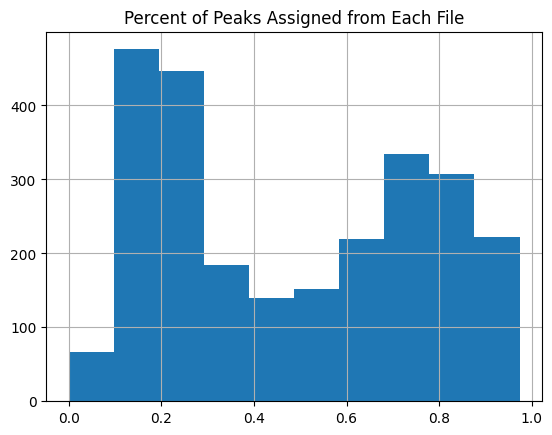

In [12]:

mol.hist("assigned_perc")
plt.title('Percent of Peaks Assigned from Each File')
plt.show()


### Perform quality control filtering of data sets using the chosen metadata information

How many data sets are in each group?

In [13]:
#expand listed columns in molecular formula df
mol_expanded=mol.explode(['mol_form','H/C','O/C','Confidence Score'])

#resave expanded columns as numeric
mol_expanded['O/C']=pd.to_numeric(mol_expanded['O/C'])
mol_expanded['H/C']=pd.to_numeric(mol_expanded['H/C'])
mol_expanded['Confidence Score']=pd.to_numeric(mol_expanded['Confidence Score'])

#metadata group column
grouping_column='sample_type_gen'

#merge to include metadata type/category
metadata_mol=mol_expanded.merge(merged_df[['processed_nom_id',grouping_column]].rename(columns={"processed_nom_id":"processed"}),on=['processed'],how="left")

#filter to datasets with more than 30% of peaks assigned
perc_assign_filt=metadata_mol[metadata_mol['assigned_perc']>0.30]

#count number of datasets in each type
count_type=perc_assign_filt[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

sample_type_gen
soil        1388
sand          81
sediment      41
water         33
Name: count, dtype: int64

Randomly sample a chosen number of data sets from each group

In [14]:
#determine sampling size based on counts above
n=30

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
sampled_data=[]
for type in list_type:
    #each processed ID and sample type
    mol_type=perc_assign_filt[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    mol_type=mol_type[mol_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    mol_type=mol_type.sample(n=n, random_state=2)
    #save
    sampled_data.append(mol_type)

#resave list as dataframe
sampled_data=pd.concat(sampled_data)

#pull rest of the data for the sampled data sets
sampled_data_merged=sampled_data.merge(perc_assign_filt,on=['processed',grouping_column],how="left")

sampled_data_merged

,processed,sample_type_gen,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-11-8n2sf788,soil,0.741882,C6 H10 O3,1.666667,0.500000,0.599672
1,nmdc:dobj-11-8n2sf788,soil,0.741882,C6 H12 O3,2.000000,0.500000,0.600000
2,nmdc:dobj-11-8n2sf788,soil,0.741882,C8 H8 O2,1.000000,0.250000,0.599999
3,nmdc:dobj-11-8n2sf788,soil,0.741882,C7 H6 O3,0.857143,0.428571,0.599948
4,nmdc:dobj-11-8n2sf788,soil,0.741882,C7 H8 O3,1.142857,0.428571,0.599656
...,...,...,...,...,...,...,...
172827,nmdc:dobj-11-4pzj0s58,water,0.436900,C9 H12 O5,1.333333,0.555556,0.581192
172828,nmdc:dobj-11-4pzj0s58,water,0.436900,C10 H14 O4,1.400000,0.400000,0.582442
172829,nmdc:dobj-11-4pzj0s58,water,0.436900,C9 H10 O5,1.111111,0.555556,0.576943
172830,nmdc:dobj-11-4pzj0s58,water,0.436900,C9 H16 O4,1.777778,0.444444,0.562836


Perform peak filtering based on confidence score and molecular formula filtering based on frequency across samples. This will leave us with the most informative data.

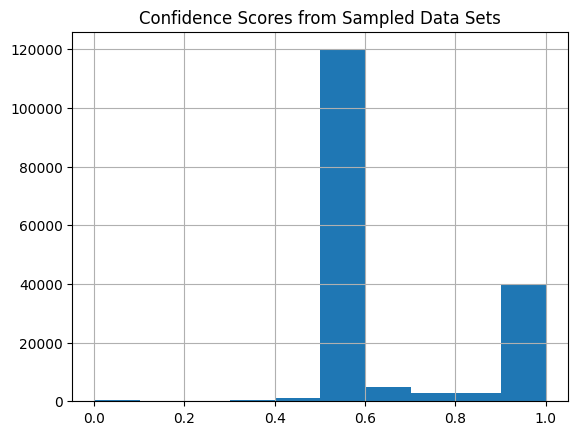

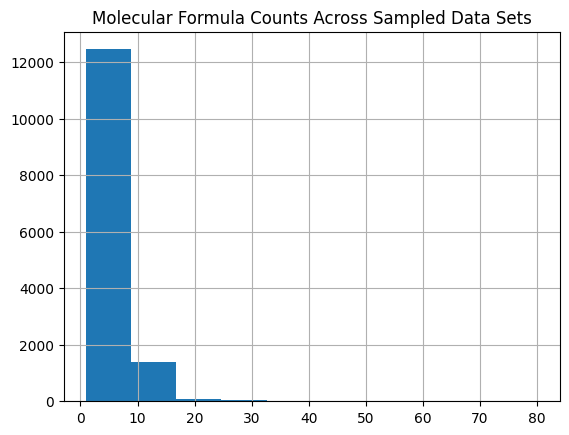

In [15]:
#histogram of confidence scores for randomly selected samples
sampled_data_merged.hist("Confidence Score")
plt.title('Confidence Scores from Sampled Data Sets')
plt.show()

#peak filtering by confidence score
peak_filt=sampled_data_merged[sampled_data_merged['Confidence Score']>0.60]

#count for each molecular formula
mol_counts=peak_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count")
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.show()

#based on this histogram, filter to formulas in more than 5 samples
mol_counts=mol_counts[mol_counts['count']>5]
mol_filter=mol_counts.merge(peak_filt,on=['mol_form'],how="left")


### Assess presence or absence of molecular formulas from different groups

Create heatmap of molecular formulas in the filtered list of processed NOM data object.

/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


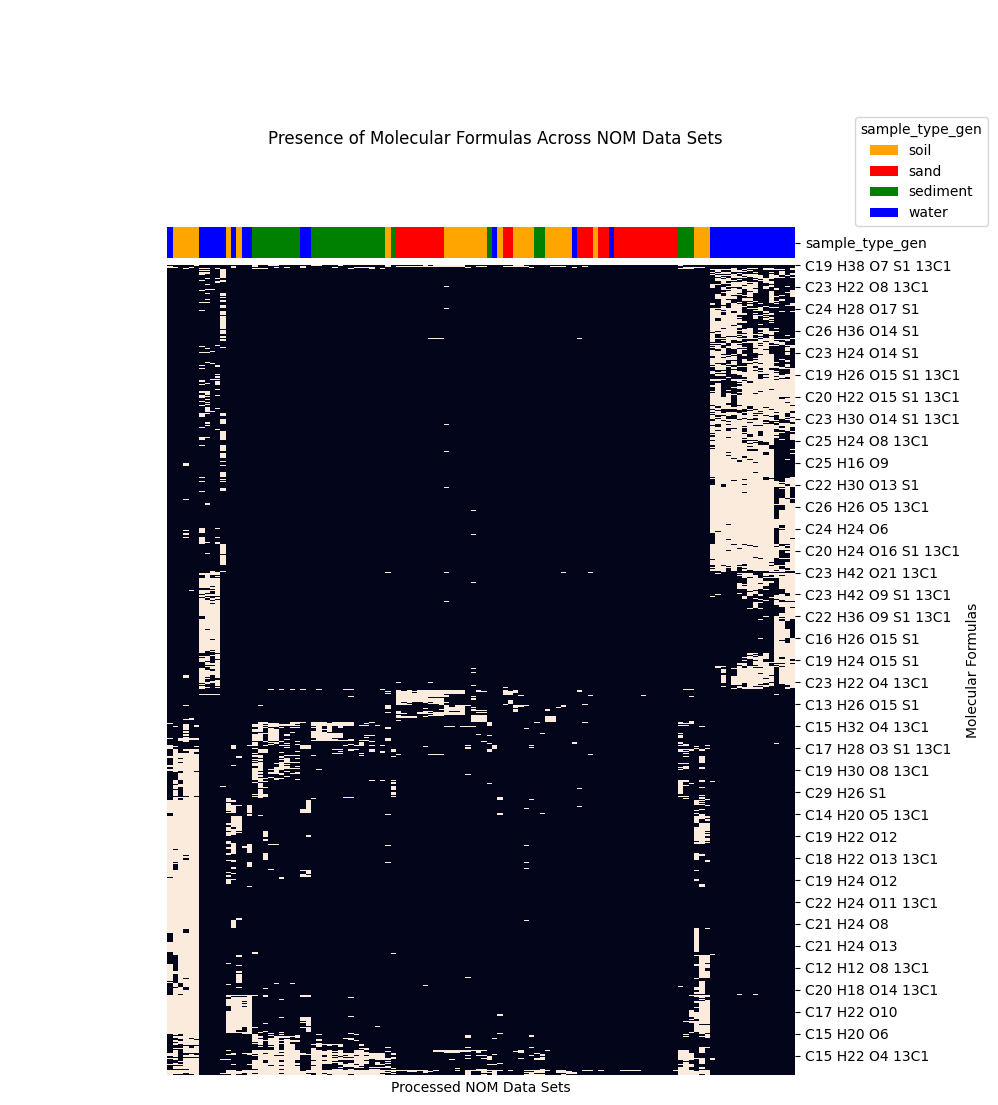

In [16]:
#set colors for each sample type
type_col=pd.DataFrame({grouping_column:mol_filter[grouping_column].unique(),'color':['orange','red','green','blue']})

#map graph colors based on sample type to processed IDs
sample_type=mol_filter[[grouping_column,'processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on=grouping_column).set_index('processed').drop(grouping_column,axis=1).rename(columns={'color':grouping_column})

#add column indicating presence in that processed nom id
mol_filter['presence']=1

#create presence/absence matrix
formula_matrix=mol_filter[['mol_form','processed','presence']].pivot_table('presence', index='mol_form', columns='processed').fillna(0).astype(int)

#setup color legend for sample type
type_col_dict = dict(zip(type_col[grouping_column].unique(), ['orange','red','green','blue']))
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#heatmap
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,cmap='rocket',cbar_pos=None)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")
g.figure.subplots_adjust(top=1.1)
plt.legend(handles, type_col_dict, title=grouping_column,
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)


### Assess molecular composition of different groups using Van Krevelen plots

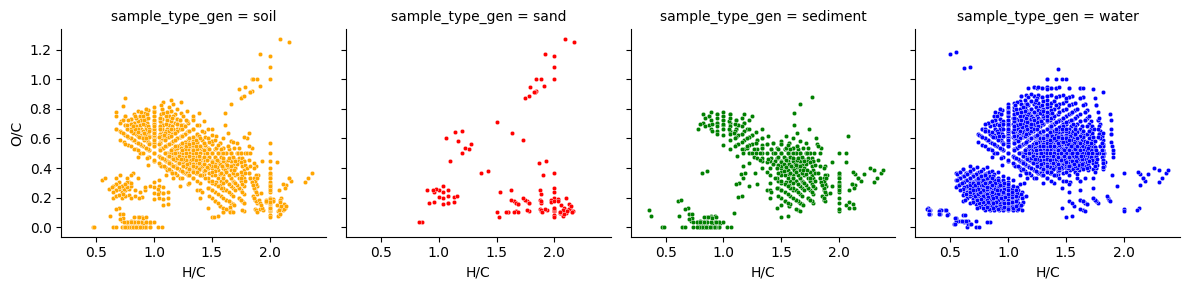

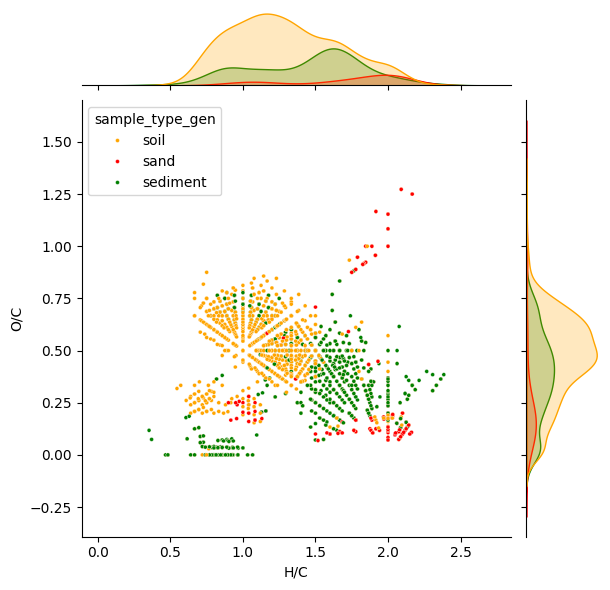

In [17]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique on these graphs per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plots
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column,palette=type_col_dict)
g.map(sns.scatterplot,'H/C','O/C',s=10)

#remove water since it overwhelms the plots
vankrev_subset=vankrev_data[~vankrev_data[grouping_column].str.contains('water')]

sns.jointplot(data=vankrev_subset, x="H/C", y="O/C", kind="scatter", hue=grouping_column,palette=type_col_dict,s=8)
plt.show()

### Redo quality control filtering using different metadata information

How many data sets are in each group?

In [18]:
grouping_column='env_medium.term.name'

#merge to include metadata type/category
metadata_mol=mol_expanded.merge(merged_df[['processed_nom_id',grouping_column]].rename(columns={"processed_nom_id":"processed"}),on=['processed'],how="left")

#filter to datasets with more than 30% of peaks assigned
perc_assign_filt=metadata_mol[metadata_mol['assigned_perc']>0.30]

#count number of datasets in each type
count_type=perc_assign_filt[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

env_medium.term.name
soil                  434
forest soil            92
agricultural soil      60
bare soil              52
meadow soil            41
sediment               41
surface water          33
grassland soil         24
forest soil            16
burned soil            12
pasture soil           12
Name: count, dtype: int64

Randomly sample a chosen number of data sets from each group

In [19]:
#determine sampling size based on counts above
n=10

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
sampled_data=[]
for type in list_type:
    #each processed ID and sample type
    mol_type=perc_assign_filt[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    mol_type=mol_type[mol_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    mol_type=mol_type.sample(n=n, random_state=2)
    #save
    sampled_data.append(mol_type)

#resave list as dataframe
sampled_data=pd.concat(sampled_data)

#pull rest of the data for the sampled data sets
sampled_data_merged=sampled_data.merge(perc_assign_filt,on=['processed',grouping_column],how="left")

sampled_data_merged

,processed,env_medium.term.name,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-11-w95wnk70,soil,0.757576,C8 H16 O2,2.000000,0.250000,0.584002
1,nmdc:dobj-11-w95wnk70,soil,0.757576,C8 H14 O3,1.750000,0.375000,0.599199
2,nmdc:dobj-11-w95wnk70,soil,0.757576,C9 H18 O2,2.000000,0.222222,0.599959
3,nmdc:dobj-11-w95wnk70,soil,0.757576,C8 H8 O4,1.000000,0.500000,0.599891
4,nmdc:dobj-11-w95wnk70,soil,0.757576,C8 H10 O4,1.250000,0.500000,0.597661
...,...,...,...,...,...,...,...
345349,nmdc:dobj-11-8rr0at69,pasture soil,0.724638,C19 H16 O14,0.842105,0.736842,0.599907
345350,nmdc:dobj-11-8rr0at69,pasture soil,0.724638,C20 H16 O14,0.800000,0.700000,0.599900
345351,nmdc:dobj-11-8rr0at69,pasture soil,0.724638,C21 H16 O14,0.761905,0.666667,0.599427
345352,nmdc:dobj-11-8rr0at69,pasture soil,0.724638,C38 H45 O8 N1,1.184211,0.210526,0.544748


Perform peak filtering based on confidence score and molecular formula filtering based on frequency across samples. This will leave us with the most informative data.

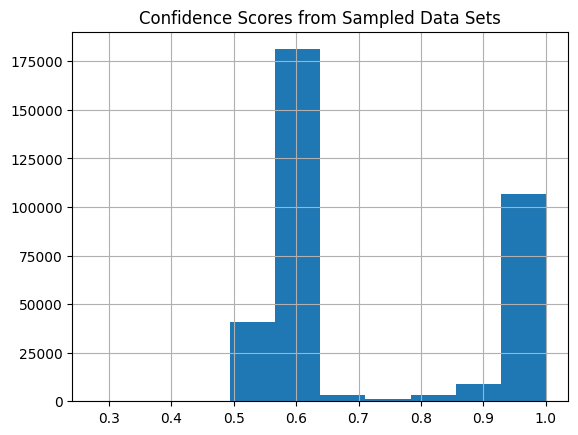

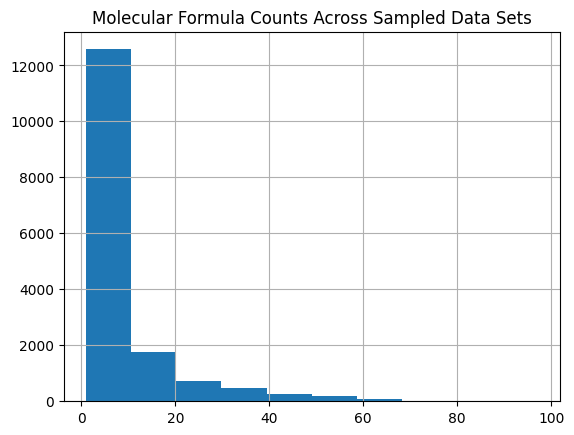

In [20]:
#histogram of confidence scores for randomly selected samples
sampled_data_merged.hist("Confidence Score")
plt.title('Confidence Scores from Sampled Data Sets')
plt.show()

#peak filtering by confidence score
peak_filt=sampled_data_merged[sampled_data_merged['Confidence Score']>0.60]

#count for each molecular formula
mol_counts=peak_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count")
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.show()

#based on this histogram, filter to formulas in more than 5 samples
mol_counts=mol_counts[mol_counts['count']>5]
mol_filter=mol_counts.merge(peak_filt,on=['mol_form'],how="left")


### Assess molecular composition of different groups using Van Krevelen plots

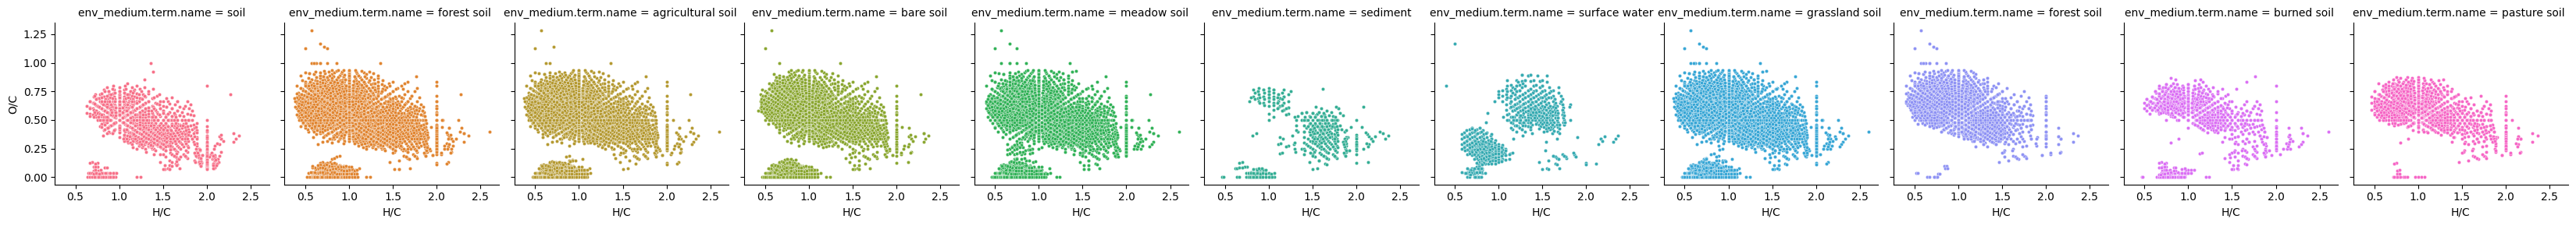

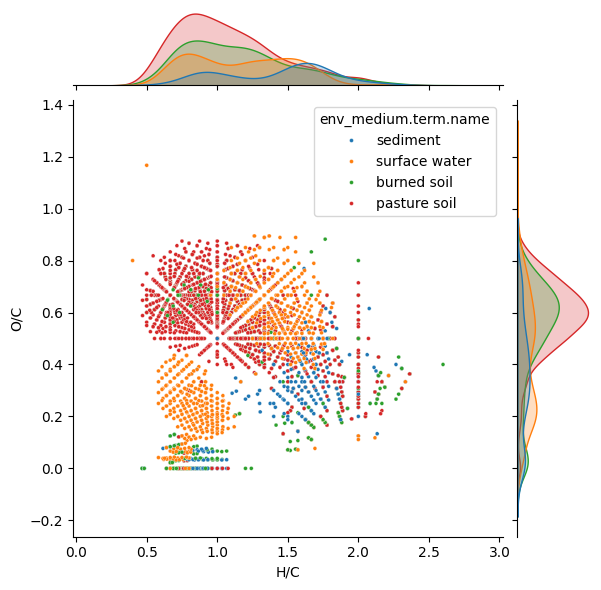

In [21]:

# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique on these graphs per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plots
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column)
g.map(sns.scatterplot,'H/C','O/C',s=10)

#subset to interest plots
vankrev_subset=vankrev_data[vankrev_data[grouping_column].str.contains('|'.join(['sediment','water','burned','pasture']))]

sns.jointplot(data=vankrev_subset, x="H/C", y="O/C", kind="scatter", hue=grouping_column,s=8)
plt.show()

